[View in Colaboratory](https://colab.research.google.com/github/spatkar94/Class-Project/blob/master/CMSC828P_TopicModelingProject.ipynb)

# CMSC 828P (Fall 2018): Topic modeling project

## Instructions


### Scope
The purpose of this project is to get you familiar with writing code to train topic models and interpret their outputs.

This notebook already includes code for downloading and processing a _simulated_ dataset of $N$ "movie reviews" over a vocabulary of $L$ words into a matrix $V$ of word counts. Each document also includes an author and a numeric rating from 0-10.

You will use open-source Python modules to:

1. Estimate the number $K$ of topics (aka the rank) of $V$.
2. Train a single topic model for $V$ using the $K$ you chose from (1).
3. Evaluate the topics you discover with the "ground truth" topics from which the simulated data was generated. The code for evaluating the topics is already provided.
4. Identify correlations between the topic mixings/allocations and authorship
5. Train supervised learners to predict ratings from documents.

Finally, I have also included code for downloading and processing a _real_ movie review dataset at the end of this notebook. The last 10% of your grade will be from an open-ended investigation of this dataset. I look forward to seeing what you can learn!

### Grading

This project will constitute 10% of your final grade. You will be graded on:

1. The results you achieve, e.g. can you discover the hidden topics?
2. The text you write in between code blocks. This text should explain both what you aim to do AND your interpretation of the results.
3. Your code and its readability.


### Getting started and FAQ

Here are two references for using Colaboratory and Jupyter notebooks (from which Colaboratory is based):

1. [Using Jupyter notebooks](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/examples_index.html). Examples and explanation of writing/executing code, [Markdown](https://en.wikipedia.org/wiki/Markdown) text (including in "math mode"), and other topics.
2. [Hello, Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true). This includes an overview of Colaboratory and its key features, as well as helpful code snippets.

To get started, execute the existing code in **Setup** and **Download and process simulated movie review dataset** below, and then begin writing your own code in **Topic modeling**.

## Setup

### Install required Python modules

In [4]:
!pip install nimfa
!pip install gensim
!pip install pydrive

    100% |████████████████████████████████| 5.7MB 868kB/s 
  Running setup.py bdist_wheel for nimfa ... - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/63/b7/fd/858ba29683d798fd121b1df0d672943449e64e2ae94fd42af3
Successfully built nimfa
    100% |████████████████████████████████| 23.6MB 1.3MB/s 
    100% |████████████████████████████████| 1.4MB 14.0MB/s 
    100% |████████████████████████████████| 133kB 26.2MB/s 
    100% |████████████████████████████████| 4.7MB 5.1MB/s 
    100% |████████████████████████████████| 61kB 13.4MB/s 
    100% |████████████████████████████████| 552kB 24.1MB/s 
  Running setup.py bdist_wheel for smart-open ... - done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
    10

### Load dependencies

Below I'm loading all the dependencies you will need to execute my code for downloading/processing data, and to help you visualize the data and some results. I'm also loading additional modules that may be of use to you.

In [0]:
# Dependencies for modeling, data download/processing, etc.
import os, numpy as np, pandas as pd, urllib.request
from collections import defaultdict, Counter
from gensim import corpora, models
import gensim, nimfa

# Load plotting libraries
import altair as alt
import matplotlib.pyplot as plt, seaborn as sns
from IPython.core.display import display, HTML
from scipy.spatial.distance import cdist
sns.set_style('whitegrid')

# Load tools for evaluating models
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr

# Dependencies for downloading data files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

### Set constants and hyperparameters

In [0]:
# Data files
SIM_DATA_FILE = 'sim-movie-review-data-docs.tsv'
SIM_TOPICS_FILE = 'sim-movie-review-data-topics.tsv'
SIM_DATA_FILE_URL = 'https://drive.google.com/uc?export=download&id=17Ltn4Mzl6PVxBUxpP8oakHWxMq0L3-bb'
SIM_TOPICS_FILE_URL = 'https://drive.google.com/uc?export=download&id=1ewxQj2T2g88X7YOahHXi8EP2sJOq2O1y'

# Hyperparameters
RANDOM_SEED = 57891

In [0]:
np.random.seed(RANDOM_SEED)

## Download and process simulated movie review dataset

Download the data file from the class Google Drive.

In [0]:
# Download the data file
_ = urllib.request.urlretrieve(SIM_DATA_FILE_URL, SIM_DATA_FILE)
_ = urllib.request.urlretrieve(SIM_TOPICS_FILE_URL, SIM_TOPICS_FILE)

First, we load the topics used to generate the data, which are now in the directory with this notebook. You will use the "ground truth" topics to validate what you discover later on. At the same time, we will also load our dataset's vocabulary.

In [10]:
# Load the known topics (for later)
with open(SIM_TOPICS_FILE, 'r') as IN:
    # Load the file
    arrs = [ l.rstrip('\n').split('\t') for l in IN ]
    header = arrs.pop(0)
    
    # Parse the vocabulary (first column)
    vocabulary = [ arr[0] for arr in arrs ]
    N_words = len(vocabulary)
    vocab_index = dict(zip(vocabulary, range(N_words)))
    
    # Parse the true topics
    N_true_topics = len(header)-1
    true_topics = np.zeros((N_true_topics, len(vocabulary)))
    for arr in arrs:
        j = vocab_index[arr[0]]
        for i in range(N_true_topics):
            true_topics[i, j] = float(arr[i+1])
            
print('- Loaded %s x %s true topic matrix' % true_topics.shape)

- Loaded 3 x 195 true topic matrix


Now, load the given simulated data, which is now in the same directory as this notebook. The input is a tab-separated file with the author name, rating, and list of space-separated (non-stop) words.

In [11]:
with open(SIM_DATA_FILE, 'r') as IN:
  arrs = [ l.rstrip('\n').split('\t') for l in IN if not l.startswith('#')]
  
  authors = sorted(set( arr[0] for arr in arrs ))
  N_authors = len(authors)
  author_id = dict(zip(authors, range(N_authors)))
  author_ids = [ author_id[arr[0]] for arr in arrs ]
  
  ratings = [ float(arr[1]) for arr in arrs ]
  
  texts = [ arr[2].split(' ') for arr in arrs ]
  N_docs = len(texts)
  
print('Loaded %s documents' % N_docs)
print('- from a vocabulary of %s words' % N_words)
print('- by %s authors' % N_authors)
print('- with ratings in [%s-%s]' % (np.min(ratings), np.max(ratings)))

Loaded 200 documents
- from a vocabulary of 195 words
- by 3 authors
- with ratings in [0.0-10.0]


Finally, we create the document-by-word count matrix using `gensim`.

In [12]:
# Copied from https://www.kaggle.com/canggih/topic-modeling
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
print('Vocabulary size: %s' % len(dictionary))

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
V = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary))

print('Number of words in all documents: %s' % sum(len(d) for d in corpus))

Vocabulary size: 195
Number of words in all documents: 15354


#### Plot some simple summaries of our data

In [13]:
# Plot the thirty most common words
word_count = Counter( w for text in texts for w in text )
word_count_df = pd.DataFrame([ dict(Word=w, Count=c) for w, c in word_count.most_common(30)])
alt.Chart(word_count_df).mark_bar().encode(
  x=alt.X('Word', sort=[ w for w, c in word_count.most_common(30) ]),
  y='Count'
).properties(
    title='Thirty most common words'
)

Chart({
  data:     Count           Word
  0     980        fantasy
  1     899          wacky
  2     859         bloody
  3     803       dramatic
  4     750  disappointing
  5     733    second-rate
  6     716         brutal
  7     711     picaresque
  8     692       powerful
  9     660    fascinating
  10    626        oddball
  11    616         tender
  12    593         uneven
  13    589      senseless
  14    584     intriguing
  15    573         cliche
  16    568    fast-moving
  17    524    imaginative
  18    521         static
  19    516      legendary
  20    490         boring
  21    485     low-budget
  22    479           will
  23    479    predictable
  24    458          bland
  25    457        comical
  26    446      enjoyable
  27    434           slow
  28    428       outdated
  29    425        violent,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'Word',
      sort: ['fantasy', 'wacky', 'bloody', 'dramatic', 'disappointing', 'second-rate', 'brutal', 'picaresque', 'powerful', 'fascinating', 'oddball', 'tender', 'uneven', 'senseless', 'intriguing', 'cliche', 'fast-moving', 'imaginative', 'static', 'legendary', 'boring', 'low-budget', 'will', 'predictable', 'bland', 'comical', 'enjoyable', 'slow', 'outdated', 'violent']
    }),
    y: Y({
      shorthand: 'Count'
    })
  }),
  mark: 'bar',
  title: 'Thirty most common words'
})

In [0]:
ratings_df = pd.DataFrame([ dict(Rating=r, Count=c) for r, c in Counter(ratings).items() ])
alt.Chart(ratings_df).mark_bar().encode(
  x='Rating:N',
  y='Count',
).properties(
    title='Distribution of ratings'
)

Chart({
  data:    Count  Rating
  0     15    10.0
  1     37     3.0
  2     31     2.0
  3     31     8.0
  4     36     7.0
  5     18     9.0
  6      9     0.0
  7     23     1.0,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'Rating:N'
    }),
    y: Y({
      shorthand: 'Count'
    })
  }),
  mark: 'bar',
  title: 'Distribution of ratings'
})

## Topic modeling

In this section, you will pick your favorite topic modeling algorithm and use it to discover topics on the movie review dataset. No matter which approach you use, you will need to come up with a procedure for selecting the number $K$ of topics. I suggest you limit your search space for $K$ to 2-10 topics.

**Implementations**. If you take a probabilistic topic modeling approach, I suggest you use [`gensim`](https://radimrehurek.com/gensim/). If you take a non-negative matrix factorization (NMF) approach, I suggest you use [`nimfa`](http://nimfa.biolab.si/index.html).

### Select $K$ and learn topics

This part has two steps.

1. Use a method discussed in class to estimate the number $K$ of topics (aka the estimated rank) in this dataset.
2.  Train one model on all the data using the $K$ you found above.

Once you've trained the model, create a $K\times L$ "topic" matrix $P$, and a $N \times K$ "mixings" matrix $E$. Don't forget to normalize $P$ so the rows are probability distributions (and renormalize $E$ accordingly)

estimated number of topics: 3


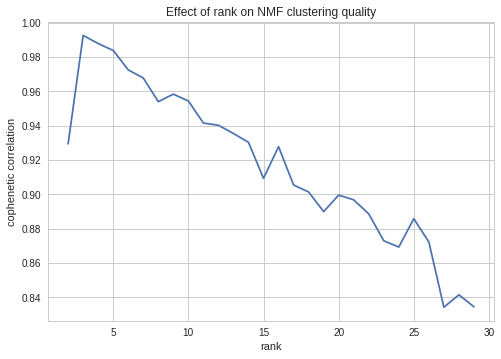

In [179]:
# YOUR CODE HERE
#grid search upper bound
MAX_K = 30

#selection of k
#objective function choice: KL dvergence, since documents are represented as a bag of words
nmf = nimfa.Nmf(V, seed="random_c", update='divergence', objective='div')

#estimating optimal rank of NMF based on cophenetic correlation metric
grid_search = nmf.estimate_rank(rank_range = range(2,MAX_K), n_run = 30, what = ['cophenetic'])

#plot cophenetic correlation as a function of the rank
rank = [grid_search[key]['rank'] for key in grid_search.keys()]
coph = [grid_search[key]['cophenetic'] for key in grid_search.keys()]
plt.plot(rank,coph)
plt.xlabel("rank")
plt.ylabel("cophenetic correlation")
plt.title("Effect of rank on NMF clustering quality")

#choosing best rank
estimated_rank = rank[coph.index(max(coph))]
print("estimated number of topics: %d"%(estimated_rank))

#training final model
final_model = nimfa.Nmf(V,seed="random_c", rank = estimated_rank, update='divergence', objective='div')
fit = final_model()

#Nomrmailization of basis and mixing matrices P,E
P = fit.basis()
E = fit.coef()
row_sums = P.sum(axis=1)
P = P / row_sums
P = P.T
col_sums = E.sum(axis=0).T
E = E.T/col_sums

#### Evaluate your topics

Now that you've chosen $K$ (the number of topics or rank) and trained a single model, we are going to evaluate the topics you've found in two ways.

1. Create a table with the top ten words per topic.
2. Compare the cosine similarity of the discovered topics with the true, hidden topics.

Below, I've provided the code for both these evaluations, and assume that you've defined an $K\times L$ topic matrix $P$ above.

In [180]:
# Take top N words per "topic"
top_n_words = 10
tbl = '<table><tr><th>Topic</th>%s</tr>' % ''.join('<th>Word %s</th>' % (i+1) for i in range(top_n_words))
for i in range(estimated_rank):
    indices = sorted(dictionary.keys(), key=lambda j: P[i, j], reverse=True)[:top_n_words]
    tbl += '<tr><td>Topic %s</td>' % (i+1)
    for idx in indices:
        tbl += '<td>%s</td>' % dictionary[idx]
    tbl += '</tr>'
tbl += '</table>'

display(HTML(tbl))

Topic,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,video,fight,care,award,boy,going,satire,le,mine,performance
Topic 2,light,ribald,shot,legendary,else,first-rate,clever,enjoyable,powerful,genre
Topic 3,effective,viewer,couple,quality,slow,lack,suspenseful,wacky,point,dead


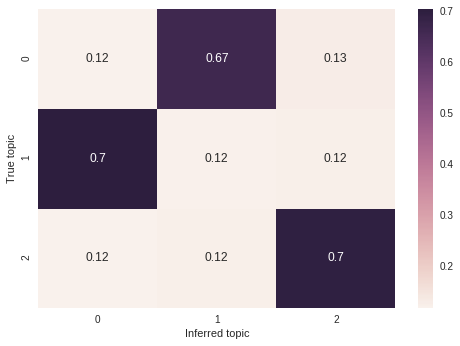

In [181]:
# Compute cosine similarity between true topics and discovered topics
reordered_vocab = [ vocab_index[w] for w in dictionary.values() ]
_ = sns.heatmap(1.-cdist(P, true_topics[:, reordered_vocab], metric='cosine'), annot=True)
_ = plt.xlabel('Inferred topic')
_ = plt.ylabel('True topic')

## Evaluation with additional data

In this section, you will analyze your topics using additional data.


### Topics by author

First, are there differences in topics depending on the author of the review? One way to find out is to cluster documents by topic and see if there are associations with authors. You can do this using a visualization, statistical test, or both.

In [182]:
# YOUR CODE HERE
from scipy import stats
topics = list(np.squeeze(np.array(E.argmax(1)),1))
df =  pd.DataFrame({'topics': topics,'authors': author_ids})

#create a contingency table describing the distribution of documents by (most dominant) topic and author
print("authors by topics")
authors_by_topics = pd.crosstab(df['topics'],df['authors'])
print(authors_by_topics)

#perform a chisq test to check if topics are associated with authors of documents
chi_sq, pval,_,_ = stats.chi2_contingency(authors_by_topics)
print("Chisq: %.2f, P-value: %f"%(chi_sq,pval))


authors by topics
authors   0   1   2
topics             
0         7  34  34
1        19  16  26
2         4  13  47
Chisq: 30.15, P-value: 0.000005


### Document ratings

Second, train a supervised learner to predict document ratings from the learned topic mixings, and evaluate your regressor on held-out data. You can use any supervised learning algorithm you like (e.g. simple linear regression, support vector machine, random forest, etc). How do the results compare to when you train your supervised learner on word counts from the document-by-word matrix (i.e. without using topics)?

In [183]:
# YOUR CODE HERE
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

#Pipeline to find the best SVM regression model in a cross-validated fashion
search = GridSearchCV(
    LinearSVR(random_state = RANDOM_SEED),
    param_grid={ 'C': np.logspace(-7, 3, 11) },
    cv=StratifiedShuffleSplit(n_splits=20, test_size=0.2), 
    n_jobs=-1, verbose=1
)

#SVM with topics as features
X = E
Y = np.array(ratings)

#Split data into train and test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size = 0.2,random_state = RANDOM_SEED)

#Perform training
search.fit(Xtrain,Ytrain)

#Evaluate on held out data using R squared  metric
R2 = search.score(Xtest,Ytest)
print("R-squared of topic model on test data: %0.2f"%(R2))




#SVM with words as features
X = V.T
Y = np.array(ratings)

#Split data into train and test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size = 0.2,random_state = RANDOM_SEED)

#Perform training
search.fit(Xtrain,Ytrain)

#Evaluate on held out data using R squared  metric
R2 = search.score(Xtest,Ytest)
print("R-squared of word model on test data: %0.2f"%(R2))




Fitting 20 folds for each of 11 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    0.4s finished


R-squared of topic model on test data: 0.86
Fitting 20 folds for each of 11 candidates, totalling 220 fits
R-squared of word model on test data: 0.38


[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    4.0s finished


## Application to real data

For the last 10% of your grade on this assignment, I am asking you to develop topic models for a real life movie review dataset.

Below, I include the code for downloading and processing the dataset. Your task is to then do an open-ended investigation of this dataset and report back. Some questions you can try and answer:

*   How many topics are there in this dataset?
*   Can you predict movie ratings using bag-of-words featurization? How about topic mixings?
*   Are some reviewers more/less likely to write about certain topics?

Or any other questions you find interesting! 

### Setup additional resources

In [184]:
!pip install nltk
!pip install stop_words

  Running setup.py bdist_wheel for stop-words ... - \ done
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
import tarfile
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [186]:
import nltk
_ = nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#### Constants/hyperparameters

In [0]:
# File/URL constants
REAL_DATA_TAR_URL = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/scale_data.tar.gz'
REAL_DATA_TAR = "movie-review-data.tar.gz"

# Dataset constants
RATING_SCALE = 4
VOCAB_SIZE = 500

### Download and process movie review dataset

We download the movie review data analyzed in the Supervised LDA paper (Blei & McAuliffe. _NIPS_, 2008) from http://www.cs.cornell.edu/people/pabo/movie-review-data/.

In [188]:
# Download the data file
urllib.request.urlretrieve(REAL_DATA_TAR_URL, REAL_DATA_TAR)

('movie-review-data.tar.gz', <http.client.HTTPMessage at 0x7f94564da6d8>)

The main processing we do is removing stop words and infrequent words. We also stem the words. This is largely based on the processing from https://www.kaggle.com/canggih/topic-modeling, and in some cases the code is copied directly.

In [0]:
# Setup tokenizer
# copied from https://www.kaggle.com/canggih/topic-modeling
pattern = r'\b[^\d\W]+\b'
tokenizer = RegexpTokenizer(pattern)
en_stop = get_stop_words('en')
lemmatizer = WordNetLemmatizer()

In [190]:
# Create a map of authors to ordered lists of documents and ratings
docs = defaultdict(list)
ratings_map = defaultdict(list)
with tarfile.open(REAL_DATA_TAR) as TAR:
  for member in TAR:
    basename = os.path.basename(member.name)
    if basename.startswith('subj') or basename.startswith('label.%sclass' % RATING_SCALE):
      author = basename.split('.')[-1]
      if basename.startswith('subj'):              
        # Extract each review as a separate document
        for line in TAR.extractfile(member):
          # clean and tokenize document string
          # code below is copied from https://www.kaggle.com/canggih/topic-modeling
          raw = line.decode("utf-8", "replace").rstrip('\n').lower()
          tokens = tokenizer.tokenize(raw)

          # remove stop words from tokens
          stopped_tokens = [raw for raw in tokens if not raw in en_stop]

          # lemmatize tokens
          lemma_tokens = [lemmatizer.lemmatize(tokens) for tokens in stopped_tokens]

          # remove word containing only single char
          new_lemma_tokens = [raw for raw in lemma_tokens if not len(raw) == 1]

          # add tokens to list for author
          docs[author].append( new_lemma_tokens )

      # Process ratings
      else:
        for line in TAR.extractfile(member):
          ratings_map[author].append( int(line.decode("utf-8", "replace").rstrip('\n')) )
          
    # Otherwise skip
    else:
      continue
      
# Summarize the data
N_docs = sum( len(ds) for ds in docs.values() )
N_authors = len(docs)
print('Loaded %s documents from %s authors' % (N_docs, N_authors))

Loaded 5006 documents from 4 authors


Now we create the document-by-word count matrix using `gensim`.

In [0]:
# Flatten out all our data for easy use later on
authors = sorted(docs.keys())
author_id = dict(zip(authors, range(N_authors)))
raw_texts = [ d for a in authors for d in docs[a] ]
ratings = [ r for a in authors for r in ratings_map[a] ]
author_ids = [ [author_id[a]] * len(docs[a]) for a in authors ]

Restrict to 500 words according to TF-IDF:

In [192]:
vect = TfidfVectorizer(min_df=3, max_df=0.5, max_features=VOCAB_SIZE).fit([ ' '.join(text) for text in raw_texts ])
vocab_set = set(vect.vocabulary_)
texts = [ [ w for w in text if w in vocab_set] for text in raw_texts ]
print('New vocabulary length: %s' % len(vocab_set))

New vocabulary length: 500


In [193]:
# Copied from https://www.kaggle.com/canggih/topic-modeling
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
print('Vocabulary size: %s' % len(dictionary))

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
V = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary))

print('Number of words in all documents: %s' % sum(len(d) for d in corpus))

Vocabulary size: 500
Number of words in all documents: 342559


### Your analysis of real data

Fill in below.

In [0]:
# YOUR CODE HERE